In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Q2 Calcualte the term structure of interest rates

# Term Structure of Interest Rates

In [2]:
def phi_t(a, b, lamda, t):
    phit = a + b*(((1-np.exp(-lamda*t))/(lamda*t))-np.exp(-lamda*t))
    return phit

def Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim, Ntime, x_0, y_0):
    x = np.full((Nsim, Ntime+1), np.nan)
    y = np.full((Nsim, Ntime+1), np.nan)
    r = np.full((Nsim, Ntime+1), np.nan)
    phi = np.full((Nsim, Ntime+1), np.nan)
    phi[:,0] = a
    r[:,0] = a + x_0 + y_0
    x[:,0] = x_0
    y[:,0] = y_0
    dt = 1/252
    t = 0
    # Set initial x_0, y_0
    for i in range(Ntime):
        Z_1 = np.random.standard_normal(Nsim)
        Z_2 = np.random.standard_normal(Nsim)
        t = (i+1)*dt
        x[:,i+1] = x[:,i] - alpha*x[:,i]*dt + sigma*np.sqrt(dt)*Z_1
        y[:,i+1] = y[:,i] - beta*y[:,i]*dt + eta*np.sqrt(dt)*Z_2
        phi[:,i+1] = phi_t(a,b,lamda,t)
        r[:,i+1]= phi[:,i+1] + x[:,i+1] +y[:,i+1]
    Pt0 = np.mean(np.exp(-np.sum(r, axis=1)*dt))
    return x,y,r,Pt0

Set basic parameters

In [3]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = 0.01
beta = 1
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
Ntime = 252*10
Nsim = 1000


x = np.full((Nsim, Ntime+1),np.nan)
y = np.full((Nsim, Ntime+1),np.nan)
r = np.full((Nsim, Ntime+1),np.nan)

x,y,r,pt0 = Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim, Ntime, x_0, y_0)



# x, y, r Analysis

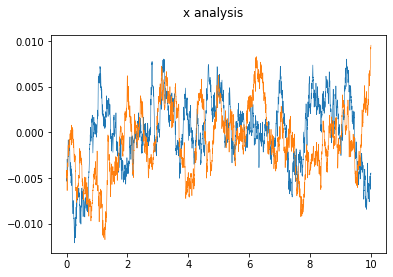

In [22]:
# Investigate x
t = np.linspace(0,10,252*10+1)
for i in range(2):
    plt.plot(t,x[i,:],linewidth=.6)
plt.suptitle('x analysis')
plt.show()

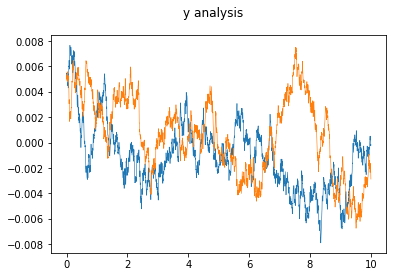

In [23]:
# Investigate y
for i in range(2):
    plt.plot(t,y[i,:], linewidth=.6)
plt.suptitle('y analysis')
plt.show()

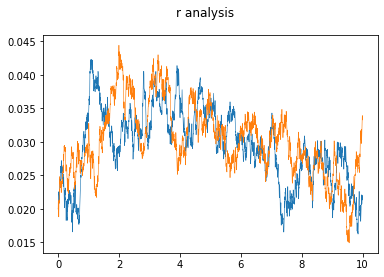

In [24]:
# Investigate r
for i in range(2):
    plt.plot(t,r[i,:], linewidth=.6)
plt.suptitle('r analysis')
plt.show()

Q3 Use 10000 paths to obtain MC estimate of bond yields

Compute bond yields through MC approach

In [101]:
# Simulation Method
from scipy.stats import norm
def Yields_mat(a, b, sigma, alpha, beta, eta, lamda, Nsim, T, x_0, y_0):
    Pt0 = []
    yt = []
    yt_upper = []
    yt_lower = []
    Ntime = T*12*21
    dt = 1/252
    r = np.full((Nsim, Ntime+1), np.nan)
    r = Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim,Ntime, x_0, y_0)[2]
    for i in range(T*12):
        length = (i+1)*21
        # Construct the 95% confidence Interval
        pt0 = np.mean(np.exp(-np.sum(r[:,0:length],axis=1)*dt))
        std = np.std(np.exp(-np.sum(r[:,0:length],axis=1)*dt))
       # std = np.std(np.log(1/np.exp(-np.sum(r[:,0:length],axis=1)*dt))/((i+1)/12))
        
        #print(std)
        Pt0 += [pt0]
        y_t = np.log(1/pt0)/((i+1)/12)
        yt += [y_t]
        yt_upper += [y_t + norm.ppf(0.975)*std/np.sqrt(Nsim)]
        yt_lower += [y_t - norm.ppf(0.975)*std/np.sqrt(Nsim)]
        
    return Pt0, yt, yt_upper, yt_lower

Compute bond yields analytically

In [102]:
from scipy.integrate import quad
def integrand(x, sigma,eta,alpha,T,beta):
    mu_t = sigma*(1-np.exp(-alpha*(T-x)))/alpha
    nu_t = eta*(1-np.exp(-beta*(T-x)))/beta
    return (mu_t**2 + nu_t**2)
def phi_t2(x, a, b, lamda):
    phit = a + b*(((1-np.exp(-lamda*x))/(lamda*x))-np.exp(-lamda*x))
    return phit

def Price_analy(a,b,lamda,sigma,eta,alpha,T,beta,y_0,x_0):
    Pt0 = []
    yt = []
    for i in range(T*12):
        At_1 = quad(phi_t2,0,(i+1)/12,args=(a,b,lamda))[0]
        At_2 = quad(integrand, 0, (i+1)/12, args=(sigma, eta, alpha, (i+1)/12, beta))[0]
        B_T = (1-np.exp(-alpha*((i+1)/12)))/alpha
        C_T = (1-np.exp(-beta*((i+1)/12)))/beta
        price = np.exp(-At_1+0.5*At_2-B_T*x_0-C_T*y_0)
        Pt0 += [price]
        yt += [np.log(1/price)/((i+1)/12)]
    #m_u = (1-np.exp(-beta*()))
    return Pt0,yt

In [103]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = 0.01
beta = 1
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
T = 10
Nsim2 = 10000
# Compute based on simulation
Pt, yt, yt_upper, yt_lower = Yields_mat(a, b, sigma, alpha, beta, eta, lamda, Nsim2,T, x_0, y_0)
# Compute analyticaly
Pt2, yt2 = Price_analy(a,b,lamda,sigma,eta,alpha,T,beta,y_0,x_0)

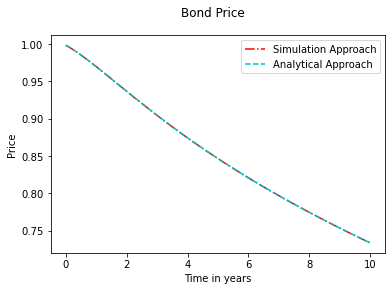

In [104]:
time = np.linspace(0,10,T*12)
plt.plot(time,Pt,'-.',color='r',label='Simulation Approach')
plt.plot(time,Pt2,'--',color='c',label='Analytical Approach')
plt.legend()
plt.xlabel('Time in years')
plt.ylabel('Price')
plt.suptitle('Bond Price')
plt.show()

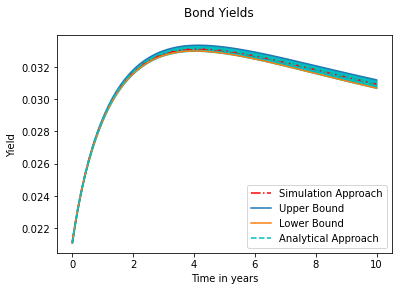

In [143]:
plt.plot(time,yt2,'-.',color='r',label='Simulation Approach')
plt.plot(time,yt_upper,label='Upper Bound')
plt.plot(time,yt_lower,label='Lower Bound')
plt.plot(time,yt,'--',color='c',label='Analytical Approach')
plt.legend()
plt.fill_between(time, yt_upper, yt_lower, color='c')
plt.xlabel('Time in years')
plt.ylabel('Yield')
plt.suptitle('Bond Yields')
plt.show()

Investigate parameters in determining he term structure 

alpha Analysis

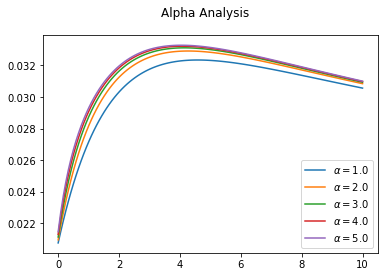

In [129]:
x_0 = -0.005
y_0 = 0.005
alpha = np.linspace(1,5,5)
sigma = 0.01
beta = 1
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
T = 10

for i in range(len(alpha)):
    Pt3, yt3 = Price_analy(a,b,lamda,sigma,eta,alpha[i],T,beta,y_0,x_0)
    plt.plot(time, yt3, label = r'$\alpha = $'+str(alpha[i]))
plt.legend()
plt.suptitle('Alpha Analysis')
plt.show()

Beta Analysis

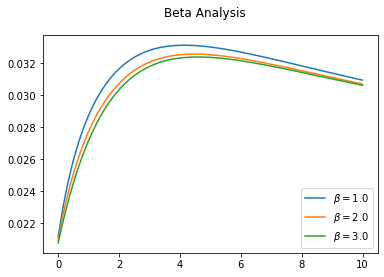

In [131]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = 0.01
beta = np.linspace(1,3,3)
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
T = 10

for i in range(len(beta)):
    Pt3, yt3 = Price_analy(a,b,lamda,sigma,eta,alpha,T,beta[i],y_0,x_0)
    plt.plot(time, yt3, label = r'$\beta = $'+str(beta[i]))
plt.legend()
plt.suptitle('Beta Analysis')
plt.show()

Sigma Analysis

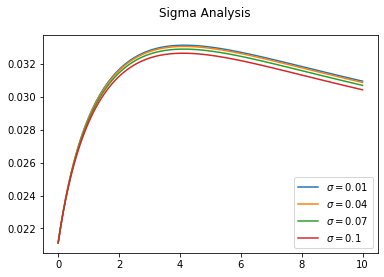

In [132]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = np.linspace(0.01, 0.1, 4)
beta = 1
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
T = 10

for i in range(len(sigma)):
    Pt3, yt3 = Price_analy(a,b,lamda,sigma[i],eta,alpha,T,beta,y_0,x_0)
    plt.plot(time, yt3, label = r'$\sigma = $'+ str(sigma[i]))
plt.legend()
plt.suptitle('Sigma Analysis')
plt.show()

Eta Analysis

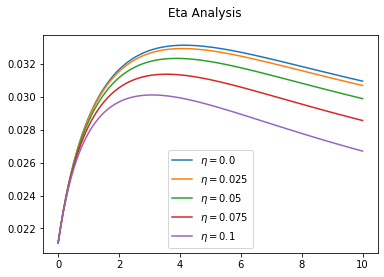

In [137]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = 0.01
beta = 1
eta = np.linspace(0, 0.1, 5)
a = 0.02
b = 0.05
lamda = 0.75
T = 10

for i in range(len(eta)):
    Pt3, yt3 = Price_analy(a,b,lamda,sigma,eta[i],alpha,T,beta,y_0,x_0)
    plt.plot(time, yt3, label = r'$\eta = $'+ str(eta[i])[0:5])
plt.legend()
plt.suptitle('Eta Analysis')
plt.show()